In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

sns.set()

from IPython.display import display
from tools import make_track, ols_regression, make_ER, lasso_regression, ridge_regression
from hc_graph import hc_stock

<IPython.core.display.Javascript object>

Open console to check js libs were loaded in page


### Financial data loads and cleaning

In [3]:
# BNP Data
#bnp = pd.read_csv(r'financial_data/bnp_data.csv', parse_dates =True, sep=";", header= [3], index_col=0)
#bnp_wanted_ticker = ["US_USDLIBOR3M","USD_EUR"]
#bnp

In [4]:
# yahoo_prices
yahoo = pd.read_csv(r"financial_data/yahoo_prices.csv", index_col=0, parse_dates=True, dayfirst=True)

# MSCI
msci = pd.read_csv(r'financial_data/msci_data.csv', index_col=0, parse_dates=True, sep=";")

# US rate
US_rate = pd.read_csv(r"financial_data/USD_rates.csv", index_col=0, parse_dates=True, dayfirst=True)['3M']

# HFRX
hfrx_all = pd.read_csv(r"financial_data/hfrx_daily_index_data.csv", index_col=0, parse_dates=True, dayfirst=True).ffill()
hfrx = make_ER(hfrx_all[['HFRXEMN']].dropna(), @)

# BNP
bnp_all = pd.read_csv(r"financial_data/bnp_data.csv", index_col=0, parse_dates=True, dayfirst=True)[['BNPIFEU',
                            'BNPIFUS', 'BNPIFJP', 'BNPIFCN', 'BNPIFFR', 'BNPIFGE', 'BNPIFGB', 'BNPIFCH', 'BNPIFKR',
                            'BNPIFUSC', 'BNPIFBR', 'BNPIFAU', 'BNPIFHK', 'BNPIFTW', 'BNPIFSG', 'BNPIFIT', 'BNPIFSP',
                            'BNPIFSW', 'BNPIFNE', 'BNPIFRU', 'BNPIFEM', 'BNPIFJT', 'BPFXEUR1', 'BPFXGBP1', 'BPFXCHF1',
                            'BPFXJPY1', 'BPFXAUD1', 'BPFXNZD1', 'BPFXNOK1', 'BPFXSEK1', 'BPFXCAD1', 'BPFXCZK1',
                            'BPFXPLN1', 'BPFXHUF1', 'BPFXTRY1', 'BPFXZAR1', 'BPFXSGD1', 'BPFXMXN1', 'BPFXINR1',
                            'BPFXKRW1', 'BPFXPHP1', 'BPFXTWD1', 'BPFXBRL1', 'BPFXCLP1', 'BPFXCOP1']]
bnp = pd.read_csv(r"financial_data/bnp_data.csv", index_col=0, parse_dates=True, dayfirst=True)[['BNPIFEU', 'BNPIFUS', 'BNPIFUSC',
                            'BNPIFJP', 'BNPIFGB', 'BNPIFCH', 'BNPIFEM', 'BPFXEUR1', 'BPFXGBP1', 'BPFXJPY1']]

In [5]:
US_rate

Date
2003-01-02    1.38000
2003-01-03    1.39000
2003-01-06    1.38875
2003-01-07    1.38750
2003-01-08    1.38000
2003-01-09    1.38000
2003-01-10    1.38000
2003-01-13    1.37563
2003-01-14    1.37313
2003-01-15    1.37000
2003-01-16    1.37000
2003-01-17    1.36875
2003-01-20    1.36375
2003-01-21    1.36250
2003-01-22    1.36000
2003-01-23    1.35250
2003-01-24    1.34938
2003-01-27    1.34125
2003-01-28    1.34000
2003-01-29    1.34000
2003-01-30    1.35000
2003-01-31    1.35000
2003-02-03    1.35000
2003-02-04    1.35000
2003-02-05    1.34875
2003-02-06    1.35000
2003-02-07    1.35000
2003-02-10    1.34938
2003-02-11    1.35000
2003-02-12    1.34000
               ...   
2017-10-06    1.35028
2017-10-09    1.35639
2017-10-10    1.35667
2017-10-11    1.35861
2017-10-12    1.35917
2017-10-13    1.35333
2017-10-16    1.35389
2017-10-17    1.35733
2017-10-18    1.36261
2017-10-19    1.36250
2017-10-20    1.36476
2017-10-23    1.36742
2017-10-24    1.37064
2017-10-25    1.37446
2017-

In [5]:
prices = bnp.copy()
#prices = prices.join(msci, how="outer")
prices = prices.join(hfrx,how="outer")

prices_all = bnp_all.copy()
#prices = prices.join(msci, how="outer")
prices_all = prices_all.join(hfrx,how="outer")

In [6]:
starts = prices.apply(lambda x:x.first_valid_index())

In [7]:
prices = prices.ffill().dropna()
returns = prices.resample('7D').first().pct_change().dropna()

prices_all = prices_all.ffill().dropna()
returns_all = prices_all.resample('7D').first().pct_change().dropna()

In [8]:
hrfx_returns = returns[["HFRXEMN"]]
bch_returns = returns.drop("HFRXEMN", axis=1)
bch_returns_all = returns_all.drop("HFRXEMN", axis=1)

size = 52
freq = 4
bounds = (-np.inf,np.inf)
total_weight = np.nan

df_weight = ols_regression(hrfx_returns, bch_returns, size, freq, boundaries=bounds, weight_sum=total_weight)
df_weight_all = ols_regression(hrfx_returns, bch_returns_all, size, freq, boundaries=bounds, weight_sum=total_weight)

prices_for_track = prices.loc[df_weight.index[0]:].drop("HFRXEMN", axis=1)
replication = make_track(prices_for_track, df_weight)

prices_for_track_all = prices_all.loc[df_weight_all.index[0]:].drop("HFRXEMN", axis=1)
replication_all = make_track(prices_for_track_all, df_weight_all)

df_res = prices.loc[replication.index][["HFRXEMN"]]
df_res["OLS"] = replication
df_res["OLS all"] = replication_all

In [37]:
df_weight_ridge_2 = ridge_regression(hrfx_returns, bch_returns, size, freq, boundaries=bounds, weight_sum=total_weight, l=5e-5)
replication_ridge_2= make_track(prices_for_track, df_weight_ridge)
df_res["Ridge 2"] = replication_ridge_2

In [38]:
df_weight_lasso = lasso_regression(hrfx_returns, bch_returns_all, size, freq, boundaries=bounds, weight_sum=total_weight, l=5e-6)
replication_lasso = make_track(prices_for_track_all, df_weight_lasso)
df_res["Lasso"] = replication_lasso

In [39]:
df_weight_ridge = ridge_regression(hrfx_returns, bch_returns_all, size, freq, boundaries=bounds,
                                       weight_sum=total_weight, l=5e-5)
replication_ridge = make_track(prices_for_track_all, df_weight_ridge)
df_res["Ridge"] = replication_ridge
df_res = df_res / df_res.iloc[0]

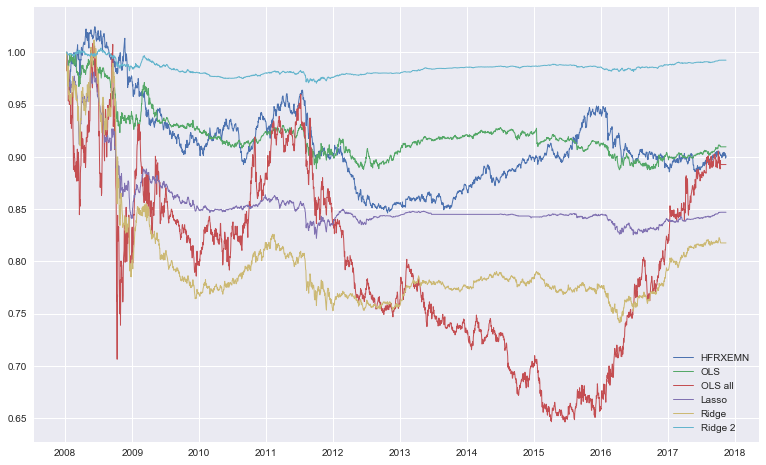

In [40]:
df_res.plot(figsize=(13,8), linewidth=1)

In [41]:
g = hc_stock(df_res)
g.plot()

In [42]:
df_res.pct_change().corr(method="pearson")

,HFRXEMN,OLS,OLS all,Lasso,Ridge,Ridge 2
HFRXEMN,1.000000,0.103402,0.085989,0.099014,0.087747,0.202120
OLS,0.103402,1.000000,0.166030,0.365961,0.302775,0.581437
OLS all,0.085989,0.166030,1.000000,0.395845,0.690695,0.170981
Lasso,0.099014,0.365961,0.395845,1.000000,0.716131,0.355840
Ridge,0.087747,0.302775,0.690695,0.716131,1.000000,0.294243
Ridge 2,0.202120,0.581437,0.170981,0.355840,0.294243,1.000000


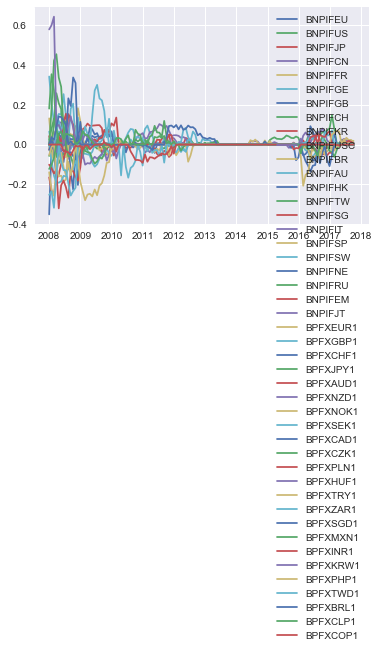

In [43]:
df_weight_lasso.plot()

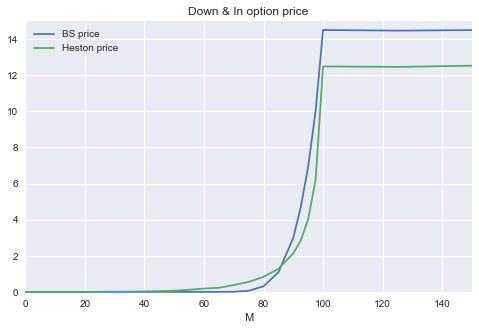

In [18]:
down_in = pd.read_csv("C:/Users/Rui Silva/Desktop/3A et Master/MNF/Vol Sto/down_in_prices.csv", index_col=0, dayfirst=True, sep=";")
down_in.plot(figsize=(8,5), title="Down & In option price", xlim=[0,150], ylim=[-0.05,15])

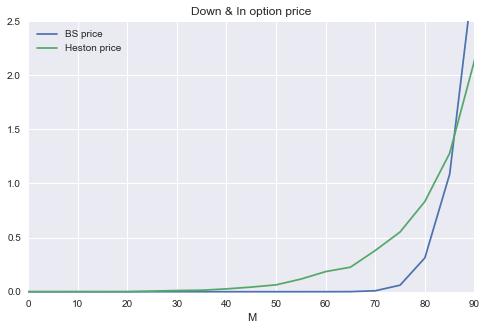

In [19]:
down_in.plot(figsize=(8,5), title="Down & In option price", xlim=[0,90], ylim=[-0.01,2.5])